# Segregação do In em poços quânticos de $In_x Ga_{1-x} As$ sobre $GaAs$

Abaixo estão as bibliotecas e configurações utilizadas.

In [2]:
# load libraries and set plot parameters
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

import scipy.constants as cte
from scipy.signal import gaussian
from scipy.special import legendre
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.integrate import simps
from scipy.optimize import newton
from scipy.interpolate import interp1d

# constantes
au_l   = cte.value('atomic unit of length')
au_t   = cte.value('atomic unit of time')
au_e   = cte.value('atomic unit of energy')
ev     = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev  = au_e / ev

## Parâmetros Macro

In [3]:
N      = 2048
z_ang  = np.linspace(-250.0, 250.0, N) # Angstrom
z_au   = z_ang / au2ang

## Funções para obtenção de níveis de energia

In [4]:
def fi(v, i):
    """
    short for flex_index, find the index i in array v
    i might be float, so that for i = 1.5, returns
    (v[2]+v[1])/2
    """
    if i < 0.0:
        return v[0]
    elif i >= len(v) - 1:
        return v[-1]
    
    try:
        i_up   = int(np.ceil(i))
        i_down = int(np.floor(i))
        return (v[i_up]+v[i_down])/2.0
    except:
        return 0.0
    
def eigenvalue(z, V, psi, m):
    """
    calculate eigenvalue like E=<Psi|H|Psi>/<Psi|Psi>
    """
    dz    = z[1]-z[0]
    dz2   = dz**2
    h_psi = np.zeros(N, dtype=np.complex_)
    
    for i in range(N):
        h_psi[i] = ((0.5/dz2)*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))+V[i])*psi[i]
        
        if i > 0:
            h_psi[i] += -(0.5/dz2)*(psi[i-1]/fi(m,i-0.5))
            
        if i < N-1:
            h_psi[i] += -(0.5/dz2)*(psi[i+1]/fi(m,i+0.5))
            
    psi_h_psi = simps(psi.conj()*h_psi, z)
    return (psi_h_psi / simps(psi.conj()*psi, z)).real
    
    
def fundamental(z, V, m):
    """
    finds the fundamental state under potential V for coordinate
    space z and effective mass m
    everything is expected to be in atomic units
    """
    
    dz  = z[1]-z[0]
    dz2 = dz**2
    
    # kick start function
    psi       = np.array(gaussian(N, std=int(N/100)), dtype=np.complex_)
    psi      /= np.sqrt(simps(psi.conj()*psi,z))
    
    sub_diag  = np.zeros(N-1, dtype=np.complex_)
    main_diag = np.zeros(N  , dtype=np.complex_)

    for i in range(N):
        try:
            main_diag[i] = (0.5/dz2)*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))+V[i]
        except:
            main_diag[i] = 0.0
        
        if i < N-1:
            sub_diag[i] = -(0.5/dz2)*(1.0/fi(m,i+0.5))
    
    diagonals = [main_diag, sub_diag, sub_diag]
    A         = diags(diagonals, [0, -1, 1]).toarray()
    invA      = inv(A)
    
    counter   = 0
    precision = 1.0
    lastval   = 100.0
    eigenval  = 0.0
    
    while True:
        counter  += 1
        psi       = invA.dot(psi)
        #psi      /= np.sqrt(simps(psi.conj()*psi, z))
        eigenval  = eigenvalue(z, V, psi, m)
        precision = np.abs(1-eigenval/lastval)
        lastval   = eigenval
        
        if precision < 1e-8:
            break
        
    
    return {
        'eigenvalue': eigenval,
        'eigenvector': psi
    }

## PL do $In_{0.14} Ga_{0.86} As$ sobre $GaAs$

Vamos agora passo a passo tentar reproduzir os valores obtidos experimentalmente.

Amostra crescida a 475 °C e PL medida a 77 K:

> ML=10, PL= 1.43922 eV

> ML=15, PL= 1.40796 ev

> ML=21, PL= 1.38241 eV

> ML=28, PL= 1.36353 eV

Amostra crescida a 525 °C e PL medida a 77 K:

> ML=10, PL= 1.45337 eV

> ML=15, PL= 1.42287 ev

> ML=21, PL= 1.39625 eV

> ML=28, PL= 1.37674 ev

Onde ML é abreviação de Monolayers (metade do parametro de rede).

Apenas para fins de comparação gradual:

In [38]:
samples = {
    'ml': [5, 9, 13, 17, 21],
    530: [1.51, 1.489, 1.459, 1.433, 1.413]
}

def sample_skeleton():
    return {
        'ml': [5,9,13,17,21],
        530: [0, 0, 0, 0, 0]
    }

R_T = {
    530: 0.85
}

x0   = 0.16 # indended indium concentration
VBO  = 0.3
CBO  = 0.7

pl_numeric = {}

Vamos começar com um poço de $InGaAs$ simples. Sendo GAP do $In_x Ga_{1-x} As$ a $2$ K dado por:

$$
E_g (x) = 1.522-1.1 x +0.4 x^2 \,\,\,\, eV
$$

Além disso, as massas efetivas do elétron e do buraco pesado na direção de crescimento (respectivamente) são dadas por:

$$
1/ m_e (x) = x/0.023 + (1-x)/0.067   \\
1/ m_{hh_z} (x) = x/0.263 + (1-x)/0.333
$$

Por fim, o parâmetro de rede é dado por:

$$
a_0 (x) = 6.0584 x + 5.6533 (1-x) \,\,\,\, Å
$$

In [39]:
eg_2 = lambda x: 1.522-1.1*x+0.4*x**2
me   = lambda x: 1.0/(x/0.023+(1-x)/0.067)
mhh  = lambda x: 1.0/(x/0.263+(1-x)/0.333)
a0   = lambda x: 6.0584*x + 5.6533*(1-x)

## Ajustando *GAP* para $77$ K

Até agora utilizamos o *GAP* do material a $0$ K, vamos utilizar esta expressão à seguir que vale para o $In_{1-x} Ga_x As$:

$$
E_g (x,T) = 0.42 + 0.625 x - \left(\frac{5.8}{T+300} - \frac{4.9}{T+271} \right) 10^{-4} T^2 x - 4.19 \, 10^{-4} \frac{T^2}{T+271} + 0.475 x^2 \,\,\,\, (eV)
$$

apenas para ter uma noção do comportamento dessa expressão, mostramos a seguir para $x=0.10$, $x=0.15$ e $x=0.20$.

**Já vamos trocar tudo que for $x$ por $1-x$ e vice-versa, pois a fórmula acima vale para $In_{1-x} Ga_x As$.**

[]

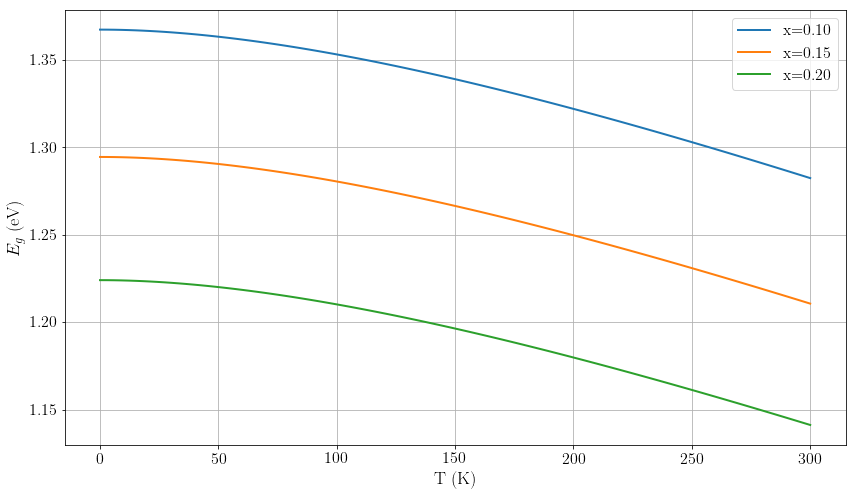

In [40]:
eg_xt_ingaas = lambda x,T: 0.42+0.625*(1-x)-(5.8/(T+300)-4.19/(T+271))*1e-4*(T**2)*(1-x) - 4.19e-4 * ((T**2)/(T+271))+0.475*(1-x)**2

T_range = np.linspace(0,300,100)
eg_10_t_ingaas = np.vectorize(eg_xt_ingaas)(100*[0.10], T_range)
eg_15_t_ingaas = np.vectorize(eg_xt_ingaas)(100*[0.15], T_range)
eg_20_t_ingaas = np.vectorize(eg_xt_ingaas)(100*[0.20], T_range)

fig, ax = plt.subplots()

x10, = ax.plot(T_range, eg_10_t_ingaas)
x15, = ax.plot(T_range, eg_15_t_ingaas)
x20, = ax.plot(T_range, eg_20_t_ingaas)
ax.grid(True)
ax.set_xlabel('T (K)')
ax.set_ylabel('$E_g$ (eV)')

plt.legend([x10, x15, x20], ['x=0.10','x=0.15','x=0.20'], loc='best')
plt.plot()

## Efeitos da tensão

vamos incluir a tensão.

In [41]:
a    = np.vectorize(lambda x: -6.08 *x+(1-x)* -8.33 )
b    = np.vectorize(lambda x: -1.55 *x+(1-x)* -1.90 )
c11  = np.vectorize(lambda x:  0.83 *x+(1-x)*  1.22 )
c12  = np.vectorize(lambda x:  0.45 *x+(1-x)*  0.57 )

## Levando em conta a segregação

Vamos começar a melhorar nosso modelo incluindo a segregação.

In [42]:
def in_segregation(x0, R, n, N=None):
    """
    return the actual indium concentration in the nth layer

    Params
    ------
    x0 : float
        the indium concentration between 0 and 1
    R : float
        the segregation coefficient
    n : int
        the current layer
    N : int
        number of layers in the well
    """
    if N:
        return x0*(1-R**N)*R**(n-N)
    return x0*(1-R**n)

O poço será construído para cada número de monolayers e envolvido em $250$ Å de cada lado.

In [43]:
def x_grid(ml, x0, R):
    """
    for a given number of intendend monolayers inside the well
    return the indium concentration in each layer plus some
    layers that will have indium in the barrier
    """
    i = 0
    x_grid = []
    while True:
        i += 1
        if i > ml:
            in_x = in_segregation(x0, R, i, ml)
        else:
            in_x = in_segregation(x0, R, i)

        if in_x < 0.0001:
            break
        x_grid.append(in_x)
    return x_grid

Exemplo, para 10 monolayers, $x=0.14$ e $R=0.9$:        

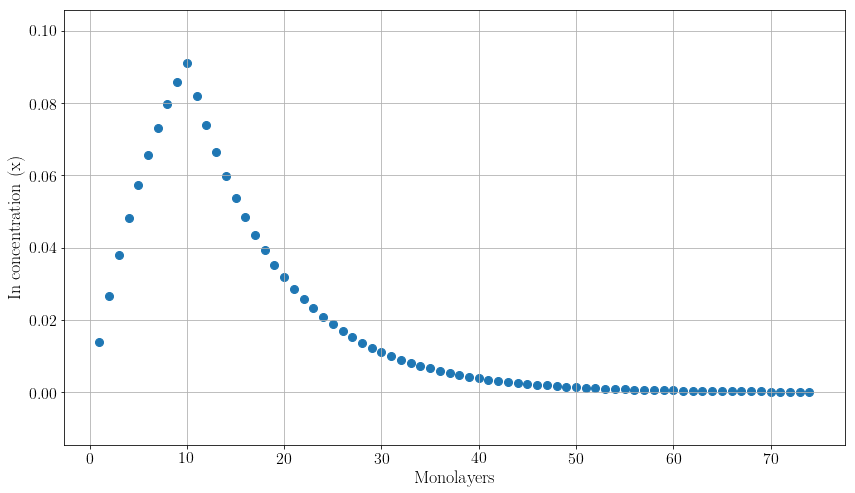

In [44]:
example_x_grid = x_grid(10, 0.14, 0.9)
fig, ax = plt.subplots()
ax.scatter(range(len(example_x_grid)+1)[1:], example_x_grid)
ax.grid(True)
ax.set_xlabel('Monolayers')
ax.set_ylabel('In concentration (x)')
plt.show()

Então nós conseguimos calcular a concentração em cada monolayer. Vamos agora gerar um grid de coordenadas z tal que o poço como o da figura acima ainda tenha $250$ Å de cada lado.

In [45]:
# saving values for future comparison
pl_numeric['segregation_temp_strain'] = sample_skeleton()
for i, ml in enumerate(samples['ml']):
    for T, R in R_T.items():
        x_well     = x_grid(ml, x0, R)
        x_barrier  = [0.0] * int(250.0 / a0(0.0))
        
        x_total    = x_barrier+x_well+x_barrier
        sys_len    = np.sum([a0(x) for x in x_total])
        z_temp     = np.linspace(-sys_len/2,sys_len/2,len(x_total))
        z_ang_in   = np.linspace(-sys_len/2,sys_len/2,N)
        f1         = interp1d(z_temp, x_total, kind='nearest')
        x_total    = f1(z_ang_in)
        
        z_au_in    = z_ang_in / au2ang
        me_in      = np.vectorize(me)(x_total)
        mhh_in     = np.vectorize(mhh)(x_total)
        #v_shape_in = np.vectorize(eg_xt_ingaas)(x_total, len(x_total)*[77])
        v_shape_in = np.vectorize(eg_xt_ingaas)(x_total, len(x_total)*[1.4])
        
        _a   = a(x_total)
        _b   = b(x_total)
        _c11 = c11(x_total)
        _c12 = c12(x_total)
        a0_vec  = np.vectorize(a0)
        
        _epp = (a0_vec([0])[0]-a0_vec(x_total))/a0_vec(x_total)
        v_shape_in = v_shape_in + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11
        
        Vc         = v_shape_in*CBO
        Vv         = v_shape_in*VBO
        Vc_red     = Vc-np.min(Vc)
        Vv_red     = Vv-np.min(Vv)
        Vc_au      = Vc_red / au2ev
        Vv_au      = Vv_red / au2ev

        GAP        = np.min(Vc+Vv)
        res_e      = fundamental(z_au_in, Vc_au, me_in)
        eigen_e    = res_e['eigenvalue'] * au2ev # in eV
        res_hh     = fundamental(z_au_in, Vv_au, mhh_in)
        eigen_hh   = res_hh['eigenvalue'] * au2ev # in eV

        PL = GAP + eigen_e + eigen_hh
    
        pl_numeric['segregation_temp_strain'][T][i] = PL
        print("T = %d C, R = %.4f, ML = %d, PL = %.4f, PL_num = %.4f" % (T, R, ml, samples[T][i], PL))

T = 530 C, R = 0.8500, ML = 5, PL = 1.5100, PL_num = 1.4841
T = 530 C, R = 0.8500, ML = 9, PL = 1.4890, PL_num = 1.4486
T = 530 C, R = 0.8500, ML = 13, PL = 1.4590, PL_num = 1.4203
T = 530 C, R = 0.8500, ML = 17, PL = 1.4330, PL_num = 1.3994
T = 530 C, R = 0.8500, ML = 21, PL = 1.4130, PL_num = 1.3843


[]

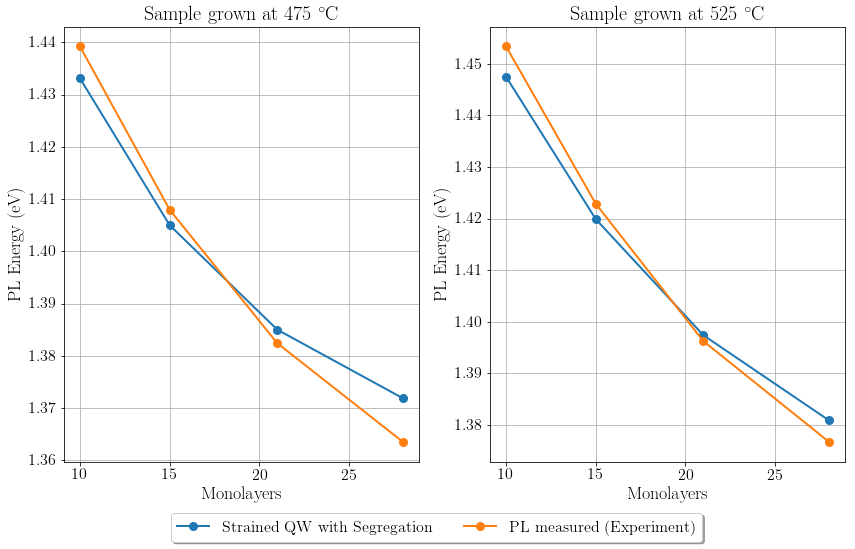

In [22]:
pl_stress_segreg_475 = pl_numeric['segregation_temp_strain'][475]
pl_stress_segreg_525 = pl_numeric['segregation_temp_strain'][525]

pl_experi_475 = samples[475]
pl_experi_525 = samples[530]

ml_grid       = samples['ml']

fig, (ax1, ax2) = plt.subplots(1,2)

strainsegreg475, = ax1.plot(ml_grid, pl_stress_segreg_475, '-o')
exp475, = ax1.plot(ml_grid, pl_experi_475, '-o')
ax1.grid(True)
ax1.set_xlabel('Monolayers')
ax1.set_ylabel('PL Energy (eV)')
ax1.title.set_text(r'Sample grown at 475 $^\circ$C')

strainsegreg525, = ax2.plot(ml_grid, pl_stress_segreg_525, '-o')
exp525, = ax2.plot(ml_grid, pl_experi_525, '-o')
ax2.grid(True)
ax2.set_xlabel('Monolayers')
ax2.set_ylabel('PL Energy (eV)')
ax2.title.set_text(r'Sample grown at 530 $^\circ$C')

plt.legend([strainsegreg525, exp475], ['Strained QW with Segregation', 'PL measured (Experiment)'],
          loc='upper center', bbox_to_anchor=(-0.15, -0.10),  shadow=True, ncol=2)
plt.plot()